필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(scb_yearly))  # type-dict
print(scb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
scb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
scb_yearly_df13 = pd.DataFrame()

for item in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[item]])

In [10]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


In [12]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

In [13]:
scb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01h,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02h,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03h,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04h,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9


유량 데이터 추가하기

In [14]:
scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['연월일시'] = scb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [18]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [19]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(scb_flow_yearly_hour_df.__len__())
print(scb_yearly_df13.__len__())

84393
82257


In [21]:
scb_yearly_df13['연월일시'] = scb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [23]:
scb_data = scb_data[:82257]

In [24]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11   상류수위(EL.m)  82231 non-null  float64
 12   하류수위(EL.m)  82231 non-null  float64
 13   유입량(㎥/s)    82231 non-null  float64
 14   방류량(㎥/s)    82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [25]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [26]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11  상류수위(EL.m)   82231 non-null  float64
 12  하류수위(EL.m)   82231 non-null  float64
 13  유입량(㎥/s)     82231 non-null  float64
 14  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [27]:
scb_data = scb_data.loc[:, list(scb_data.columns)[:3]  + list(scb_data.columns)[4:5] + list(scb_data.columns)[6:-5] + list(scb_data.columns)[-4:-3] + list(scb_data.columns)[-1:]]

In [28]:
scb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
scb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
dtype: int64

In [30]:
scb_data.isnull().sum() /len(scb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

In [31]:
len(scb_data)

82257

시간데이터 추가

In [32]:
scb_df = scb_data.copy()

In [33]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(scb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    scb_df[str(i) + 'shift 수온'] = scb_df['수온 ℃'].shift(i)

In [37]:
len(scb_df)

82257

In [38]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 수온',
       '2shift 수온', '3shift 수온', '4shift 수온', '5shift 수온', '6shift 수온',
       '7shift 수온', '8shift 수온', '9shift 수온', '10shift 수온', '11shift 수온',
       '12shift 수온', '13shift 수온', '14shift 수온', '15shift 수온', '16shift 수온',
       '17shift 수온', '18shift 수온', '19shift 수온', '20shift 수온', '21shift 수온',
       '22shift 수온', '23shift 수온', '24shift 수온', '25shift 수온', '26shift 수온',
       '27shift 수온', '28shift 수온', '29shift 수온', '30shift 수온', '31shift 수온',
       '32shift 수온', '33shift 수온', '34shift 수온', '35shift 수온', '36shift 수온',
       '37shift 수온', '38shift 수온', '39shift 수온', '40shift 수온', '41shift 수온',
       '42shift 수온', '43shift 수온', '44shift 수온', '45shift 수온', '46shift 수온',
       '47shift 수온', '48shift 수온'],
      dtype='object')

In [39]:
len(scb_df)

82257

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
scb_df = scb_df.copy()

In [42]:
scb_df['측정일/월'] = scb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
scb_df = scb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
scb_df = scb_df.dropna()

In [45]:
scb_df.__len__()

80154

In [46]:
scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 수온', '2shift 수온',
       '3shift 수온', '4shift 수온', '5shift 수온', '6shift 수온', '7shift 수온',
       '8shift 수온', '9shift 수온', '10shift 수온', '11shift 수온', '12shift 수온',
       '13shift 수온', '14shift 수온', '15shift 수온', '16shift 수온', '17shift 수온',
       '18shift 수온', '19shift 수온', '20shift 수온', '21shift 수온', '22shift 수온',
       '23shift 수온', '24shift 수온', '25shift 수온', '26shift 수온', '27shift 수온',
       '28shift 수온', '29shift 수온', '30shift 수온', '31shift 수온', '32shift 수온',
       '33shift 수온', '34shift 수온', '35shift 수온', '36shift 수온', '37shift 수온',
       '38shift 수온', '39shift 수온', '40shift 수온', '41shift 수온', '42shift 수온',
       '43shift 수온', '44shift 수온', '45shift 수온', '46shift 수온', '47shift 수온',
       '48shift 수온'],
      dtype='object')

In [47]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),1shift 수온,...,39shift 수온,40shift 수온,41shift 수온,42shift 수온,43shift 수온,44shift 수온,45shift 수온,46shift 수온,47shift 수온,48shift 수온
측정일/월,,,,,,,,,,,,,,,,,,,,,
2013-03-29 16:00:00,용봉,12.733333,294.0,3.366667,5.866,0.104,43.533333,7.535000,12.343333,12.866667,...,12.7,12.8,12.9,13.0,13.0,13.0,13.3,13.9,14.4,14.5
2013-03-29 17:00:00,용봉,12.600000,293.0,3.300000,5.850,0.105,45.200000,7.540000,13.275000,12.733333,...,12.6,12.7,12.8,12.9,13.0,13.0,13.0,13.3,13.9,14.4
2013-03-29 18:00:00,용봉,12.700000,298.0,3.400000,5.809,0.106,48.000000,7.541667,15.973333,12.600000,...,12.4,12.6,12.7,12.8,12.9,13.0,13.0,13.0,13.3,13.9
2013-03-29 19:00:00,용봉,12.700000,299.0,3.400000,5.822,0.107,50.100000,7.533333,15.346667,12.700000,...,12.4,12.4,12.6,12.7,12.8,12.9,13.0,13.0,13.0,13.3
2013-03-29 20:00:00,용봉,12.500000,299.0,3.300000,5.812,0.106,50.300000,7.530000,14.615000,12.700000,...,12.3,12.4,12.4,12.6,12.7,12.8,12.9,13.0,13.0,13.0


In [48]:
col = list(scb_df.columns[1:])
#print(col)

In [49]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

피처 정규화 없이

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [51]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [52]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [53]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [54]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.942884,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.941993,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.940321,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.937758,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.929352,5


In [55]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [56]:
estimator = gb_grid.best_estimator_

In [57]:
pred = estimator.predict(X_test)

In [58]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.09 수온 ℃
0.25 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.13 상류수위(EL.m)
0.11 방류량(㎥/s)
0.01 1shift 수온
0.03 2shift 수온
0.01 3shift 수온
0.01 4shift 수온
0.0 5shift 수온
0.01 6shift 수온
0.0 7shift 수온
0.0 8shift 수온
0.0 9shift 수온
0.0 10shift 수온
0.0 11shift 수온
0.0 12shift 수온
0.0 13shift 수온
0.0 14shift 수온
0.0 15shift 수온
0.0 16shift 수온
0.0 17shift 수온
0.0 18shift 수온
0.0 19shift 수온
0.0 20shift 수온
0.0 21shift 수온
0.0 22shift 수온
0.0 23shift 수온
0.0 24shift 수온
0.01 25shift 수온
0.0 26shift 수온
0.0 27shift 수온
0.0 28shift 수온
0.0 29shift 수온
0.0 30shift 수온
0.0 31shift 수온
0.0 32shift 수온
0.0 33shift 수온
0.0 34shift 수온
0.0 35shift 수온
0.0 36shift 수온
0.0 37shift 수온
0.0 38shift 수온
0.01 39shift 수온
0.0 40shift 수온
0.01 41shift 수온
0.0 42shift 수온
0.0 43shift 수온
0.0 44shift 수온
0.0 45shift 수온
0.0 46shift 수온
0.0 47shift 수온
0.01 48shift 수온


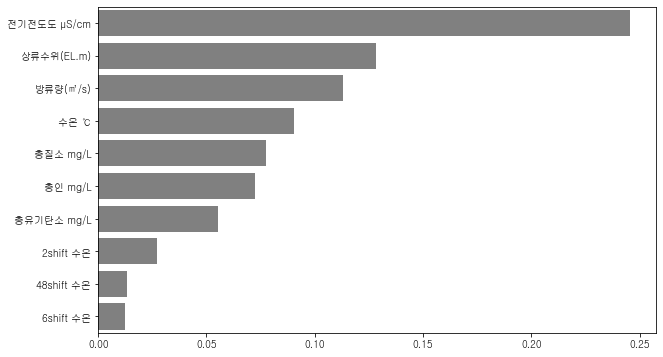

In [59]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [60]:
feature_series[:10]

전기전도도 μS/cm    0.245418
상류수위(EL.m)     0.128241
방류량(㎥/s)       0.112894
수온 ℃           0.090258
총질소 mg/L       0.077454
총인 mg/L        0.072553
총유기탄소 mg/L     0.055357
2shift 수온      0.027361
48shift 수온     0.013125
6shift 수온      0.012456
dtype: float64

In [61]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9620799572785376


피처 정규화

In [62]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [63]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 수온,2shift 수온,3shift 수온,...,39shift 수온,40shift 수온,41shift 수온,42shift 수온,43shift 수온,44shift 수온,45shift 수온,46shift 수온,47shift 수온,48shift 수온
0,-0.625427,-0.567492,-1.099594,0.207057,-0.375331,0.722272,-0.173845,-0.607984,-0.590539,-0.590520,...,-0.629150,-0.616060,-0.602971,-0.589882,-0.589867,-0.589850,-0.550614,-0.472157,-0.406774,-0.393687
1,-0.642856,-0.578842,-1.166677,0.198992,-0.360653,0.725522,-0.165679,-0.625413,-0.607967,-0.590520,...,-0.642224,-0.629134,-0.616045,-0.602956,-0.589867,-0.589850,-0.589835,-0.550599,-0.472143,-0.406760
2,-0.629784,-0.522092,-1.066053,0.178325,-0.345975,0.726605,-0.142030,-0.642841,-0.625396,-0.607949,...,-0.668371,-0.642207,-0.629118,-0.616030,-0.602940,-0.589850,-0.589835,-0.589821,-0.550586,-0.472130
3,-0.629784,-0.510742,-1.066053,0.184878,-0.331297,0.721189,-0.147522,-0.629770,-0.642825,-0.625378,...,-0.668371,-0.668355,-0.642192,-0.629103,-0.616014,-0.602924,-0.589835,-0.589821,-0.589807,-0.550573
4,-0.655927,-0.510742,-1.166677,0.179838,-0.345975,0.719023,-0.153935,-0.629770,-0.629753,-0.642807,...,-0.681445,-0.668355,-0.668339,-0.642177,-0.629088,-0.615997,-0.602909,-0.589821,-0.589807,-0.589794


In [64]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [65]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [66]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [67]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [68]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.943101,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.941996,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.940788,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.937741,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.929341,5


In [69]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [70]:
estimators = gb_grids.best_estimator_

In [71]:
preds = estimators.predict(X_tests)

In [72]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.09 수온 ℃
0.25 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.13 상류수위(EL.m)
0.11 방류량(㎥/s)
0.01 1shift 수온
0.03 2shift 수온
0.01 3shift 수온
0.01 4shift 수온
0.0 5shift 수온
0.01 6shift 수온
0.0 7shift 수온
0.0 8shift 수온
0.0 9shift 수온
0.0 10shift 수온
0.0 11shift 수온
0.0 12shift 수온
0.0 13shift 수온
0.0 14shift 수온
0.0 15shift 수온
0.0 16shift 수온
0.0 17shift 수온
0.0 18shift 수온
0.0 19shift 수온
0.0 20shift 수온
0.0 21shift 수온
0.0 22shift 수온
0.0 23shift 수온
0.0 24shift 수온
0.01 25shift 수온
0.0 26shift 수온
0.0 27shift 수온
0.0 28shift 수온
0.0 29shift 수온
0.0 30shift 수온
0.0 31shift 수온
0.0 32shift 수온
0.0 33shift 수온
0.0 34shift 수온
0.0 35shift 수온
0.0 36shift 수온
0.0 37shift 수온
0.0 38shift 수온
0.0 39shift 수온
0.0 40shift 수온
0.01 41shift 수온
0.0 42shift 수온
0.0 43shift 수온
0.0 44shift 수온
0.0 45shift 수온
0.0 46shift 수온
0.0 47shift 수온
0.01 48shift 수온


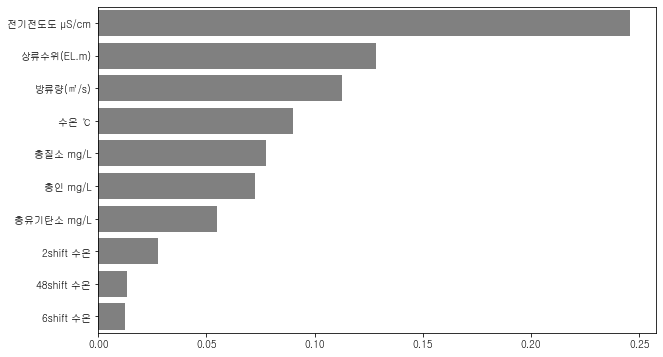

In [73]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [74]:
feature_seriess[:10]

전기전도도 μS/cm    0.245549
상류수위(EL.m)     0.128443
방류량(㎥/s)       0.112846
수온 ℃           0.090095
총질소 mg/L       0.077667
총인 mg/L        0.072298
총유기탄소 mg/L     0.054941
2shift 수온      0.027724
48shift 수온     0.013221
6shift 수온      0.012436
dtype: float64

In [75]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9628203534079418
